<center><img src="img/logo.png"></center>

<h1><center>Seminar</center></h1>
<h2><center>Clustering. K-Means. Quality Metrics.</center></h2>

# About

The goal of this seminar is to consider K-Means algorithm for clustering, implement it and demonstrate how it works. Moreover, we will consider several quality metrics and will see how to use them to tune clustering algorithms.

In [1]:
import pandas as pd
import numpy as np
import numpy.testing as np_testing
import matplotlib.pyplot as plt

%matplotlib inline

# Part 1: K-Means

## Data Preparation

In [2]:
from sklearn import datasets

n_samples = 1500
random_state = 170
X, y = datasets.make_blobs(centers=5, n_samples=n_samples, random_state=random_state, center_box=(-10, 10))

# To play with
# X, y = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)
# X, y = datasets.make_moons(n_samples=n_samples, noise=.05)
# X = np.random.rand(n_samples, 2)

In [3]:
# example of object in the feature matrix
X[:5]

array([[-5.00501671,  0.11459513],
       [ 2.27738452, -0.118907  ],
       [ 8.406718  , -0.86503325],
       [ 5.11429625, -9.12590002],
       [-9.41312681, -4.70382878]])

In [4]:
# example of cluster labels
y[:5]

array([1, 2, 4, 3, 0])

In [5]:
# we will use the function below to plot clusters and results of clustering algorithms

def plot_clusters(X, y):

    # Create an figure with a custom size
    # plt.figure(figsize=(6, 4))
    
    if y is not None:
        for cluster_label in np.unique(y):
            # Plot all objects with y == i (class 0)
            plt.scatter(X[y == cluster_label, 0],     # selects all objects with y == i and the 1st column of X
                        X[y == cluster_label, 1],     # selects all objects with y == i and the 2nd column of X
                        label=str(cluster_label))     # label for the plot legend
    else:
        plt.scatter(X[:, 0], X[:, 1], label='samples')

    plt.xlabel('X1', size=12) # set up X-axis label
    plt.ylabel('X2', size=12) # set up Y-axis label
    plt.xticks(size=12)
    plt.yticks(size=12)

    plt.legend(loc='best', fontsize=12) # create the plot legend and set up it position
    plt.grid(b=1) # create grid on the plot

    plt.show() # display the plot

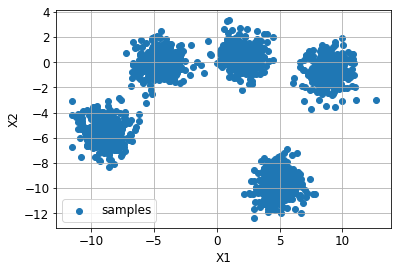

In [6]:
# show clusters in the sample
plot_clusters(X, y=None)

## K-Means Algorithm

Suppose we have $N$ samples and $K$ clusters. Each cluster is described by its center (centroid) with coordinates $\mu_{j}$. The centroids are estimated by minimizing **within-cluster distance criterion**:

$$
L = \sum_{i=1}^{N} \min_{\mu_{k}} \rho(x_{i}, \mu_{k}) \to \min_{\mu_{1}, ..., \mu_{K}}
$$

$$
\rho(x_{i}, \mu_{k}) = || x_{i} - \mu_{k} ||^{2}
$$

where $x_{i}$ is an object coordinates, $\rho(x_{i}, \mu_{k})$ is distance between the $i$-th object and the $k$-th cluster's centroid.

**K-Means algorithm:**

<center><img src="img/kmeans-alg.png" width=400></center>

<center><img src="img/kmean1.png" width=500></center>

### Task 1

Implement cluster centers initialization.

**Hint:** use `sklearn.utils.resample()` function with `random_state=11` and `replace=False`.

In [7]:
from sklearn.utils import resample

def init_cluster_centers(X, n_clusters):
    """
    Initialize cluster centers.

    Parameters:
    -----------
    X: numpy.array
        Object coordinates.
    n_clusters: int
        Number of clusters.
    
    Returns:
    --------
    cluster_centers: numpy.array
        Initialized cluster centers.
    """
    
    cluster_centers = resample(X, n_samples=n_clusters, random_state=11, replace=False)
    
    return cluster_centers

In [8]:
cluster_centers = init_cluster_centers(X, n_clusters=5)
cluster_centers

array([[ 4.90859405, -9.47195561],
       [ 0.93873614,  0.72814128],
       [-3.97968071,  0.54670645],
       [-8.54689292, -5.7938369 ],
       [ 9.78203287, -1.31122135]])

Expected output:

<center>   
    
```python
array([[ 4.90859405, -9.47195561],
       [ 0.93873614,  0.72814128],
       [-3.97968071,  0.54670645],
       [-8.54689292, -5.7938369 ],
       [ 9.78203287, -1.31122135]])
    
``` 
    
</center>

### Task 2

For the given cluster centers find cluster labels for each object in the sample. An object is assigned to the closest center based on euclidean distance. 

**Hint:** create a matrix of distances between the objects and cluster centers. Each row in this matrix corresponds to one object, each column corresponds to one cluster. Then, use `np.argmin()` function to find the closest center for each object.

In [9]:
def predict_for_centers(cluster_centers, X):
    """
    Predict cluster labels based on their centroids.

    Parameters:
    -----------
    cluster_centers: numpy.array
        Array of the cluster centers.
    X: numpy.array
        Object coordinates.

    Returns:
    --------
    labels: numpy.array
        Predicted cluster labels. Example: labels = [0, 0, 1, 1, 0, 2, ...].
    """

    object_distances2 = []
    for one_cluster_center in cluster_centers:
        dist2 = ((X - one_cluster_center)**2).sum(axis=1)
        object_distances2.append(dist2)
    object_distances2 = np.array(object_distances2)

    labels = np.argmin(object_distances2, axis=0)

    return labels

In [10]:
labels = predict_for_centers(cluster_centers, X)
labels[:10]

array([2, 1, 4, 0, 3, 1, 0, 4, 4, 2])

Expected output:

<center>   
    
```python
array([2, 1, 4, 0, 3, 1, 0, 4, 4, 2])
    
``` 
    
</center>

## Task 3

Recalculate cluster centers using cluster labels estimated previously. 

**Hint:** select all objects from one cluster and find mean values of the object coordinates in this cluster. Repeat this for all clusters.

In [11]:
def calculate_cluster_centers(X, labels):
    """
    Estimate cluster centers based on objects in these clusters.

    Parameters:
    -----------
    X: numpy.array
        Object coordinates.
    labels: numpy.array
        Cluster labels of the objects.

    Returns:
    --------
    cluster_centers: numpy.array
        Estimated cluster centers.
    """

    
    cluster_centers = []
    cluster_labels = np.unique(labels)

    for one_cluster_label in cluster_labels:
        one_cluster_center = X[labels == one_cluster_label].mean(axis=0)
        cluster_centers.append(one_cluster_center)

    return np.array(cluster_centers)

In [12]:
new_cluster_centers = calculate_cluster_centers(X, labels)
new_cluster_centers

array([[ 4.86847219, -9.7376866 ],
       [ 1.94782782,  0.47149765],
       [-4.57265217, -0.02942499],
       [-8.8991547 , -5.41650701],
       [ 8.87178022, -0.71222366]])

Expected output:

<center>   
    
```python
array([[ 4.86847219, -9.7376866 ],
       [ 1.94782782,  0.47149765],
       [-4.57265217, -0.02942499],
       [-8.8991547 , -5.41650701],
       [ 8.87178022, -0.71222366]])
    
``` 
    
</center>

### Task 4

Bring all steps together. Using functions from the previous tasks, finish `fit()` method of the class below.

In [13]:
class MyKmeans(object):
    
    def __init__(self, n_clusters=2, max_iter=10):
        """
        K-Means clustering algorithms implementation.
        
        Parameters:
        -----------
        n_clusters: int
            Number of clusters.
        max_iters: int
            Number of iterations of the centroids search.
        """
        
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        
        # to store found centers
        self.cluster_centers = None
    
    def fit(self, X):
        """
        Run k-Means algorithm for randomly init cluster centers.
        
        Parameters:
        -----------
        X: numpy.array
            Samples coordinates.
        """
        
        # Init cluster centers
        
        cluster_centers = init_cluster_centers(X, self.n_clusters)
        # Search for cluster centers
        for i in range(self.max_iter):
            labels = predict_for_centers(cluster_centers, X)
            cluster_centers = calculate_cluster_centers(X, labels)
            
        self.cluster_centers = cluster_centers
    
    
    def predict(self, X):
        """
        Predict cluster labels.
        
        Parameters:
        -----------
        X: numpy.array
            Samples coordinates.
        
        Returns:
        --------
        y: numpy.array
            Predicted cluster labels. Example: labels = [0, 0, 1, 1, 0, 2, ...].
        """
        
        y = predict_for_centers(self.cluster_centers, X)
        
        return y

In [14]:
clusterer = MyKmeans(n_clusters=5, max_iter=20)
clusterer.fit(X)
y_pred = clusterer.predict(X)

y_pred[:10]

array([2, 1, 4, 0, 3, 1, 0, 4, 4, 2])

Expected output:

<center>   
    
```python
array([2, 1, 4, 0, 3, 1, 0, 4, 4, 2])
    
``` 
    
</center>

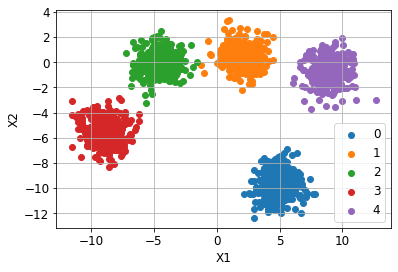

In [15]:
# show results of our K-Means algorithm
plot_clusters(X, y_pred)

# Part 2: Quality Metrics

## Data Prepration

In [16]:
from sklearn import datasets

n_samples = 1500
random_state = 170
n_true_clusters = np.random.RandomState(42).randint(5, 15, 1)[0]
X, y = datasets.make_blobs(centers=n_true_clusters, n_features=10, 
                           n_samples=n_samples, random_state=random_state, center_box=(-10, 10))

# To play with
# X, y = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)
# X, y = datasets.make_moons(n_samples=n_samples, noise=.05)
# X = np.random.rand(n_samples, 2)

In [17]:
# example of object in the feature matrix
X[:2]

array([[ 0.99344339, -0.89337969, -2.15784893, -0.43148636, -9.43358152,
         2.80202479,  3.84977177, -9.24618861,  0.2332514 ,  4.92895554],
       [-7.79262514,  5.54176793, -5.63872553,  3.07350367, 10.17760444,
         5.9834759 , -0.06660814,  8.60245823, 10.09320544, -5.69267   ]])

In [18]:
# example of cluster labels
y[:5]

array([7, 3, 5, 0, 6])

## Metrics

**Silhouette Score:**

$$
s = \frac{b - a}{max(a, b)}
$$

- **a**: The mean distance between a sample and all other points in the same class.
- **b**: The mean distance between a sample and all other points in the next nearest cluster.


**Adjusted Rand Index (ARI):**

$$
ARI = \frac{RI - Expected\_RI}{max(RI) - Expected\_RI}
$$

$$
RI = \frac{TP+TN}{TP+TN+FP+FN}
$$


- TP – number of pairs in the same cluster in predictions and the ground truth,
- TN – number of pairs from different clusters in predictions and the ground truth,
- FP – number of pairs in the same cluster in predictions, but from different clusters    in the ground truth,
- FN – number of pairs in the same cluster in the ground truth, but from the different clusters in predictions.


**Fowlkes-Mallows Index (FMI):**

$$
FMI = \frac{TP}{\sqrt{(TP+FP)(TP+FN)}}
$$

In [19]:
from sklearn.cluster import KMeans
from sklearn import metrics

# list to collect metric values
silhouette_score_values = []
adjusted_rand_score_values = []
fmi_score_values = []
within_cluster_dist_values = []

# number of clusters range
n_clusters = np.arange(2, 21)


for n in n_clusters:
    
    # run K-Means lgorithms
    clusterer = KMeans(n_clusters=n, max_iter=10, n_init=10)
    clusterer.fit(X)
    y_pred = clusterer.predict(X)
    
    # silhouette score
    score1 = metrics.silhouette_score(X, y_pred)
    silhouette_score_values.append(score1)
    
    # ARI
    score2 = metrics.adjusted_rand_score(y, y_pred)
    adjusted_rand_score_values.append(score2)
    
    # FMI
    score3 = metrics.fowlkes_mallows_score(y, y_pred)
    fmi_score_values.append(score3)
    
    # within cluster dist
    score4 = clusterer.inertia_ # sum of squared distances of samples to their closest cluster center
    within_cluster_dist_values.append(score4)

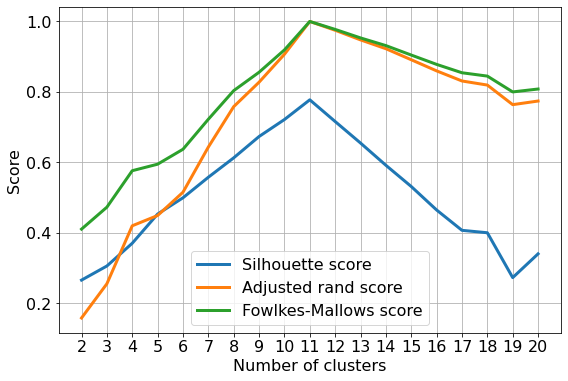

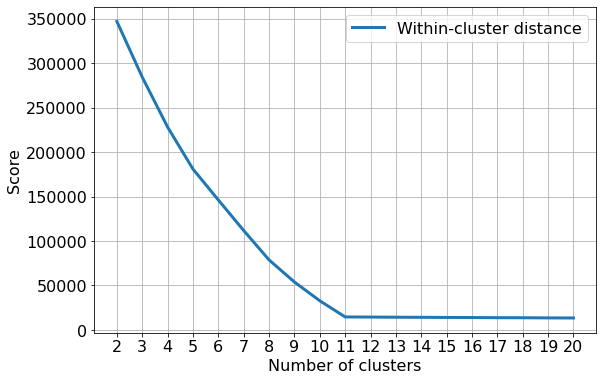

In [20]:
# Plot metric dependencies from number of clusters

plt.figure(figsize=(9, 6))
plt.plot(n_clusters, silhouette_score_values, linewidth=3, label='Silhouette score')
plt.plot(n_clusters, adjusted_rand_score_values, linewidth=3, label='Adjusted rand score')
plt.plot(n_clusters, fmi_score_values, linewidth=3, label='Fowlkes-Mallows score')
plt.xlabel('Number of clusters', size=16)
plt.ylabel('Score', size=16)
plt.xticks(n_clusters, size=16)
plt.yticks(size=16)
plt.legend(loc='best', fontsize=16)
plt.grid(b=1)
plt.show()


plt.figure(figsize=(9, 6))
plt.plot(n_clusters, within_cluster_dist_values, linewidth=3, label='Within-cluster distance')
plt.xlabel('Number of clusters', size=16)
plt.ylabel('Score', size=16)
plt.xticks(n_clusters, size=16)
plt.yticks(size=16)
plt.legend(loc='best', fontsize=16)
plt.grid(b=1)
plt.show()

### Task 5

Using metric plots above, estimate true number of clusters in the sample.

In [21]:
# to see the answer, uncomment the code below:

print("True number of clusters: ", n_true_clusters)

True number of clusters:  11


# Part 3: Real Data Example (Advanced)

In this part you need to apply K-Means algorithm to a real data sample to find groups of people with similar interests based on their facebook profile. 

The sample has columns: 
* Year of creation
* Gender
* Age
* Number of friends
* 36 keywords that are found in the facebook profile (interests, community, meetings)

In [22]:
# reading data
df_sns = pd.read_csv('data/snsdata.csv', sep=',')
df_sns.head()

,gradyear,gender,age,friends,basketball,football,soccer,softball,volleyball,swimming,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,2006,M,18.982,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2006,F,18.801,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2006,M,18.335,69,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2006,F,18.875,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2006,NaN,18.995,10,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


## Create matrix X

In [23]:
df_sns.columns

Index(['gradyear', 'gender', 'age', 'friends', 'basketball', 'football',
       'soccer', 'softball', 'volleyball', 'swimming', 'cheerleading',
       'baseball', 'tennis', 'sports', 'cute', 'sex', 'sexy', 'hot', 'kissed',
       'dance', 'band', 'marching', 'music', 'rock', 'god', 'church', 'jesus',
       'bible', 'hair', 'dress', 'blonde', 'mall', 'shopping', 'clothes',
       'hollister', 'abercrombie', 'die', 'death', 'drunk', 'drugs'],
      dtype='object')

In [24]:
word_cols = ['basketball', 'football',
             'soccer', 'softball', 'volleyball', 'swimming', 'cheerleading',
             'baseball', 'tennis', 'sports', 'cute', 'sex', 'sexy', 'hot', 'kissed',
             'dance', 'band', 'marching', 'music', 'rock', 'god', 'church', 'jesus',
             'bible', 'hair', 'dress', 'blonde', 'mall', 'shopping', 'clothes',
             'hollister', 'abercrombie', 'die', 'death', 'drunk', 'drugs']

X = df_sns[word_cols].values

## Apply K-Means

In [25]:
# apply K-Means
clusterer = KMeans(n_clusters=10, max_iter=10, n_init=10)
clusterer.fit(X)
y_pred = clusterer.predict(X)

In [26]:
# calculate quality metric
metrics.silhouette_score(X, y_pred)

0.19319771052187665

In [27]:
# get coordinates of the found cluster centers
cluster_centers = clusterer.cluster_centers_

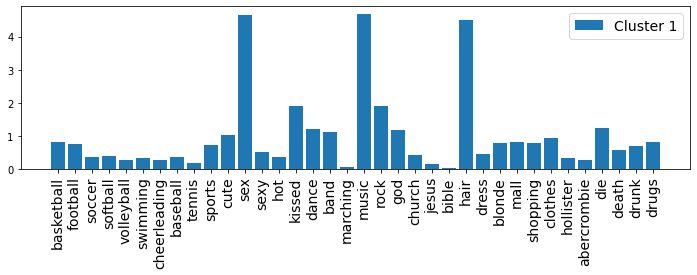

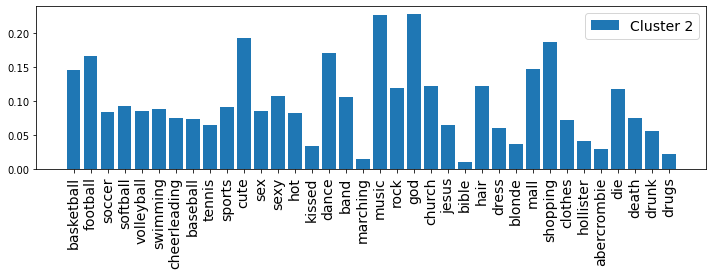

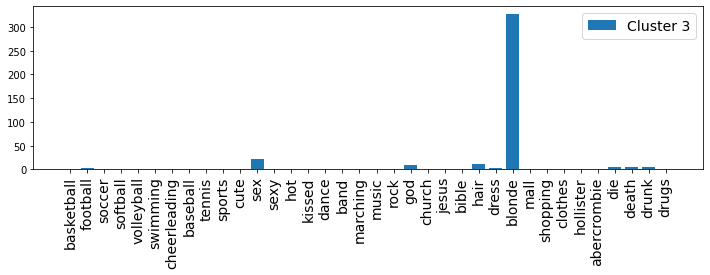

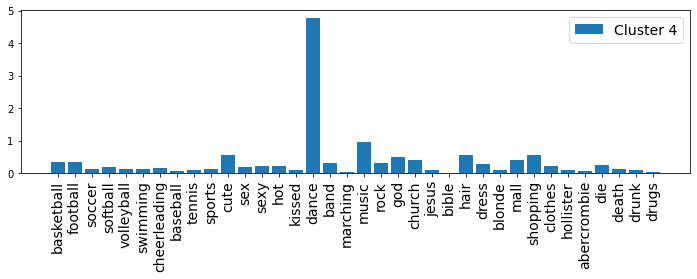

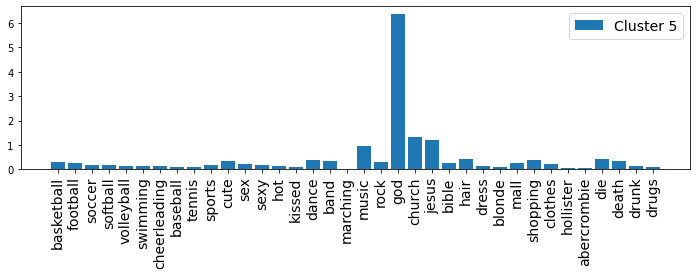

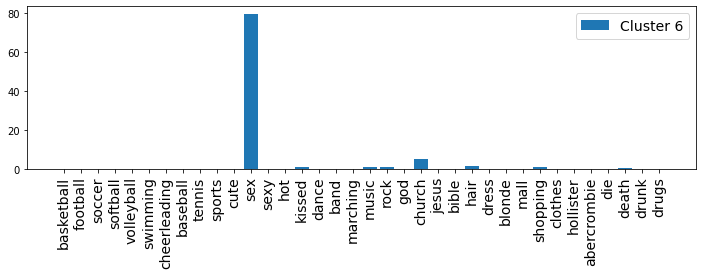

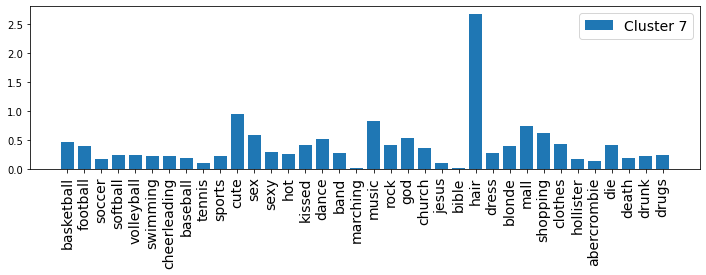

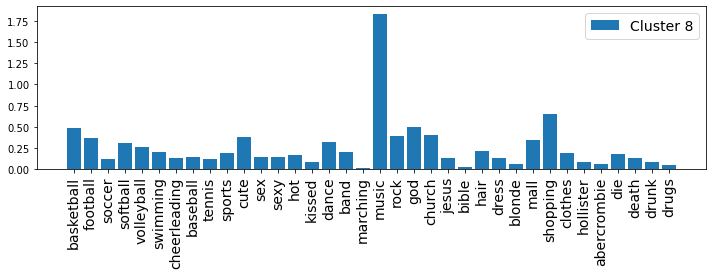

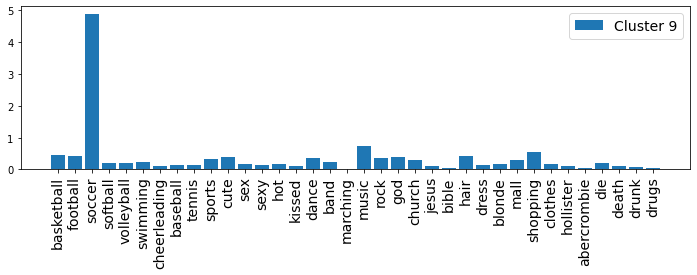

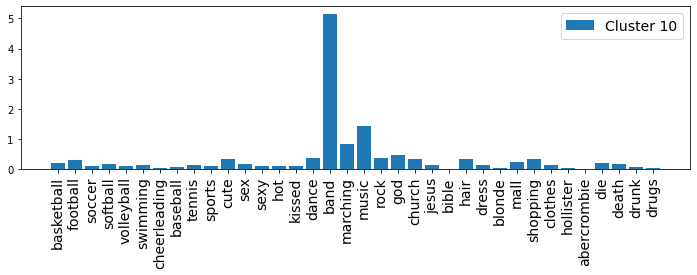

In [28]:
# plot cluster centers

for i in range(len(cluster_centers)):
    plt.figure(figsize=(12, 3))
    plt.bar(np.arange(cluster_centers.shape[1]), cluster_centers[i], label="Cluster "+str(i+1))
    plt.xticks(np.arange(len(word_cols)), word_cols, rotation=90, size=14)
    plt.legend(loc='best', fontsize=14)
    plt.show()

### Task 6

Find the optimal number of clusters in the sample. 

**Hint:** try to plot dependency of quality metrics from number of clusters. Which metrics will you choose? 